# Forecasting Bus Demand in Banana Republic Municipalities

## Load Data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv('./municipality_bus_utilization.csv')

In [3]:
df

,timestamp,municipality_id,usage,total_capacity
0,2017-06-04 07:59:42,9,454,1332
1,2017-06-04 07:59:42,8,556,2947
2,2017-06-04 07:59:42,4,1090,3893
3,2017-06-04 07:59:42,0,204,2813
4,2017-06-04 07:59:42,7,718,2019
...,...,...,...,...
13065,2017-08-19 16:30:35,2,548,697
13066,2017-08-19 16:30:35,8,1193,2947
13067,2017-08-19 16:30:35,7,1354,2019
13068,2017-08-19 16:30:35,6,1680,3113


## Data Preprocessing

In [4]:
df['timestamp'] =  pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp')

In [5]:
df.dropna()
df.loc[:, (df != df.iloc[0]).any()] 

,timestamp,municipality_id,usage,total_capacity
0,2017-06-04 07:59:42,9,454,1332
1,2017-06-04 07:59:42,8,556,2947
2,2017-06-04 07:59:42,4,1090,3893
3,2017-06-04 07:59:42,0,204,2813
4,2017-06-04 07:59:42,7,718,2019
...,...,...,...,...
13064,2017-08-19 16:30:35,5,202,587
13065,2017-08-19 16:30:35,2,548,697
13066,2017-08-19 16:30:35,8,1193,2947
13067,2017-08-19 16:30:35,7,1354,2019


In [6]:
df[['municipality_id', 'total_capacity']].groupby(['municipality_id', 'total_capacity']).count()

,
municipality_id,total_capacity
0,2813
1,397
2,697
3,1930
4,3893
5,587
6,3113
7,2019
8,2947


In [7]:
df.dtypes

timestamp          datetime64[ns]
municipality_id             int64
usage                       int64
total_capacity              int64
dtype: object

In [8]:
df.describe()

,municipality_id,usage,total_capacity
count,13070.000000,13070.000000,13070.000000
mean,4.500000,876.002984,1972.800000
std,2.872391,679.287109,1144.074782
min,0.000000,11.000000,397.000000
25%,2.000000,403.000000,697.000000
50%,4.500000,692.000000,1974.500000
75%,7.000000,1190.000000,2947.000000
max,9.000000,3508.000000,3893.000000


In [9]:
hourly_df = df.groupby([pd.Grouper(key='timestamp', freq='60Min'), 'municipality_id', 'total_capacity']).max()
hourly_df = hourly_df.reset_index() 
hourly_df.set_index('timestamp', inplace=True)

In [10]:
hourly_df

,municipality_id,total_capacity,usage
timestamp,,,
2017-06-04 07:00:00,0,2813,204
2017-06-04 07:00:00,1,397,129
2017-06-04 07:00:00,2,697,273
2017-06-04 07:00:00,3,1930,623
2017-06-04 07:00:00,4,3893,1090
...,...,...,...
2017-08-19 16:00:00,5,587,239
2017-08-19 16:00:00,6,3113,1727
2017-08-19 16:00:00,7,2019,1450


In [11]:
df_plot = hourly_df.copy()

In [13]:
df_plot['date'] = df_plot.index
df_plot['hour'] = df_plot['date'].dt.hour
df_plot['dayofweek'] = df_plot['date'].dt.dayofweek
df_plot['quarter'] = df_plot['date'].dt.quarter
df_plot['month'] = df_plot['date'].dt.month
df_plot['year'] = df_plot['date'].dt.year
df_plot['dayofyear'] = df_plot['date'].dt.dayofyear
df_plot['dayofmonth'] = df_plot['date'].dt.day
df_plot['weekofyear'] = df_plot['date'].dt.isocalendar().week

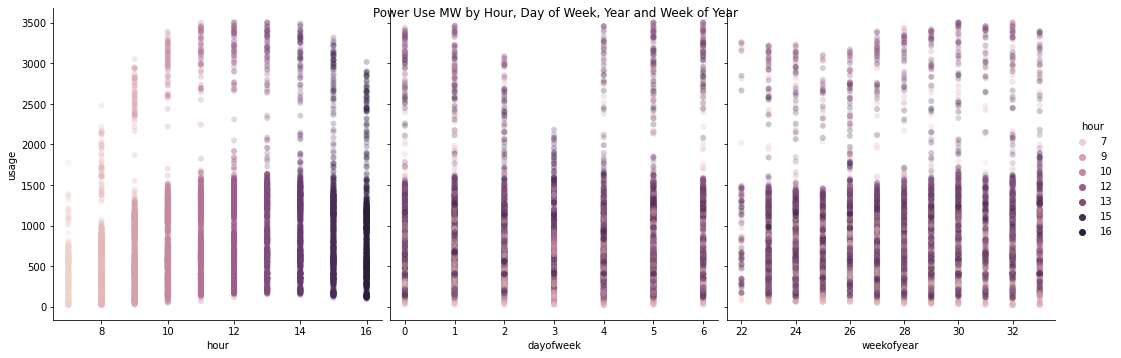

In [14]:
sns.pairplot(df_plot.dropna(),
             hue='hour',
             x_vars=['hour','dayofweek','weekofyear'],
             y_vars='usage',
             height=5,
             plot_kws={'alpha':0.25, 'linewidth':0}
            )
plt.suptitle('Power Use MW by Hour, Day of Week, Year and Week of Year')
plt.show()

In [15]:
def normalize_data(df):
    scaler = MinMaxScaler()
    df['usage']=scaler.fit_transform(df['usage'].values.reshape(-1,1))
    return df

hourly_df = normalize_data(hourly_df)

In [16]:
train_df = pd.concat([hourly_df[(hourly_df.index <= '2017-08-05')]])
test_df = hourly_df[(hourly_df.index > '2017-08-05')]

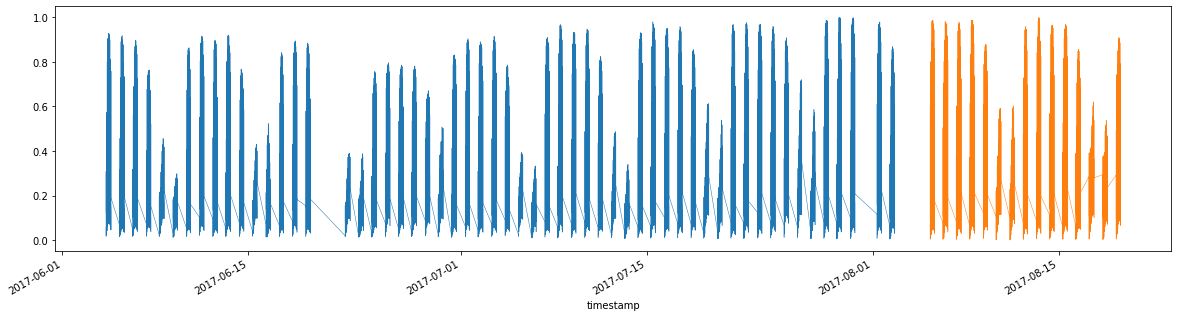

In [17]:
train_df['usage'].plot(linewidth=0.5, figsize=(20, 5));
test_df['usage'].plot(linewidth=0.5, figsize=(20, 5));

## Models

**Basic Models:** XGB, LR, NN, KNN, RF, SVR

**Complex Model:** RNN

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

In [19]:
y_train = train_df['usage']
X_train = train_df.drop(['usage'], axis = 1)
y_test = test_df['usage']
X_test = test_df.drop(['usage'], axis = 1)

In [22]:
def plot_compare_pred(y_pred, y_true, name):
    """
    Plot in red color the predicted data and in green color the
    actual data to verify visually the accuracy of the model.
    """
    fig_verify = plt.figure(figsize=(30, 10))
    plt.plot(y_pred, color="red")
    plt.plot(y_true, color="green")
    plt.title('prediction')
    plt.ylabel('value')
    plt.xlabel('row')
    plt.legend(['predicted', 'actual data'], loc='upper left')
    plt.show()
    fig_verify.savefig(name + ".png")
    plt.close()

XGB: Score: 0.101742


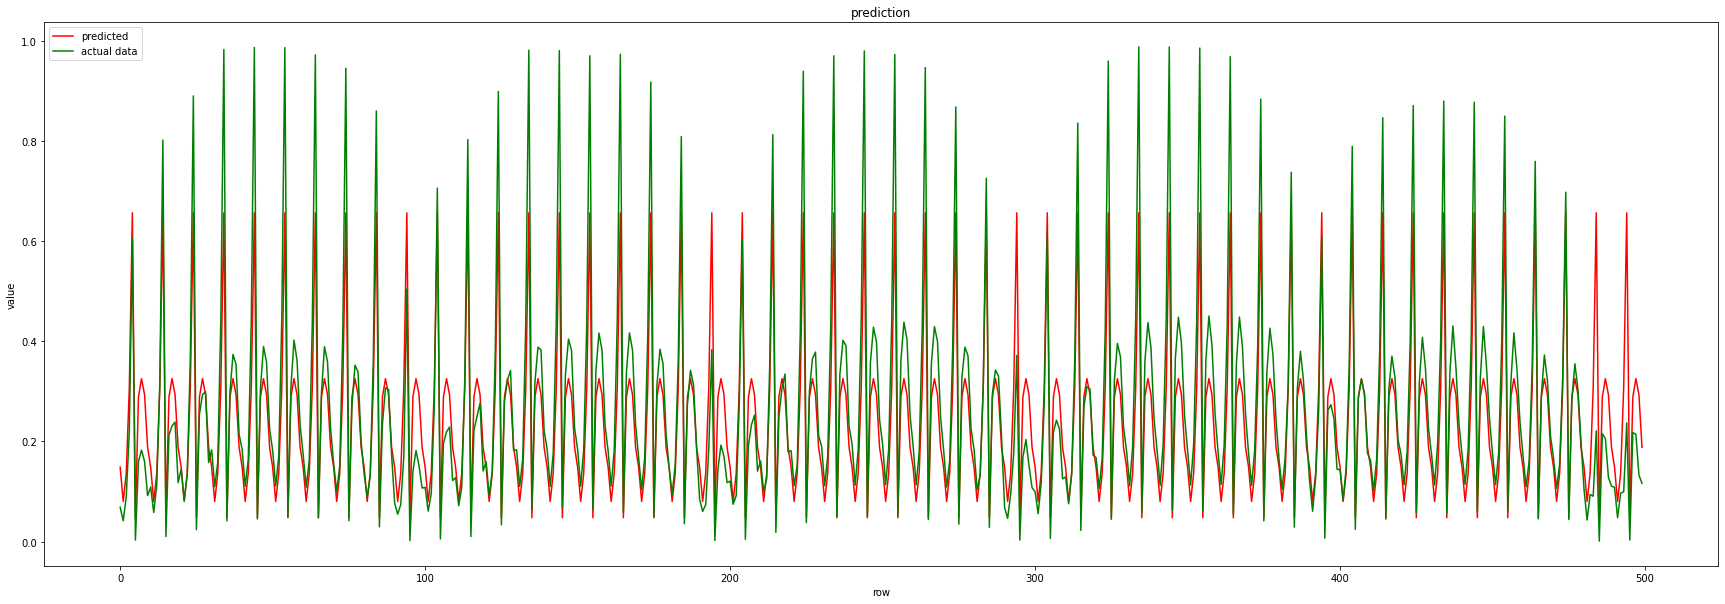

LR: Score: 0.146155


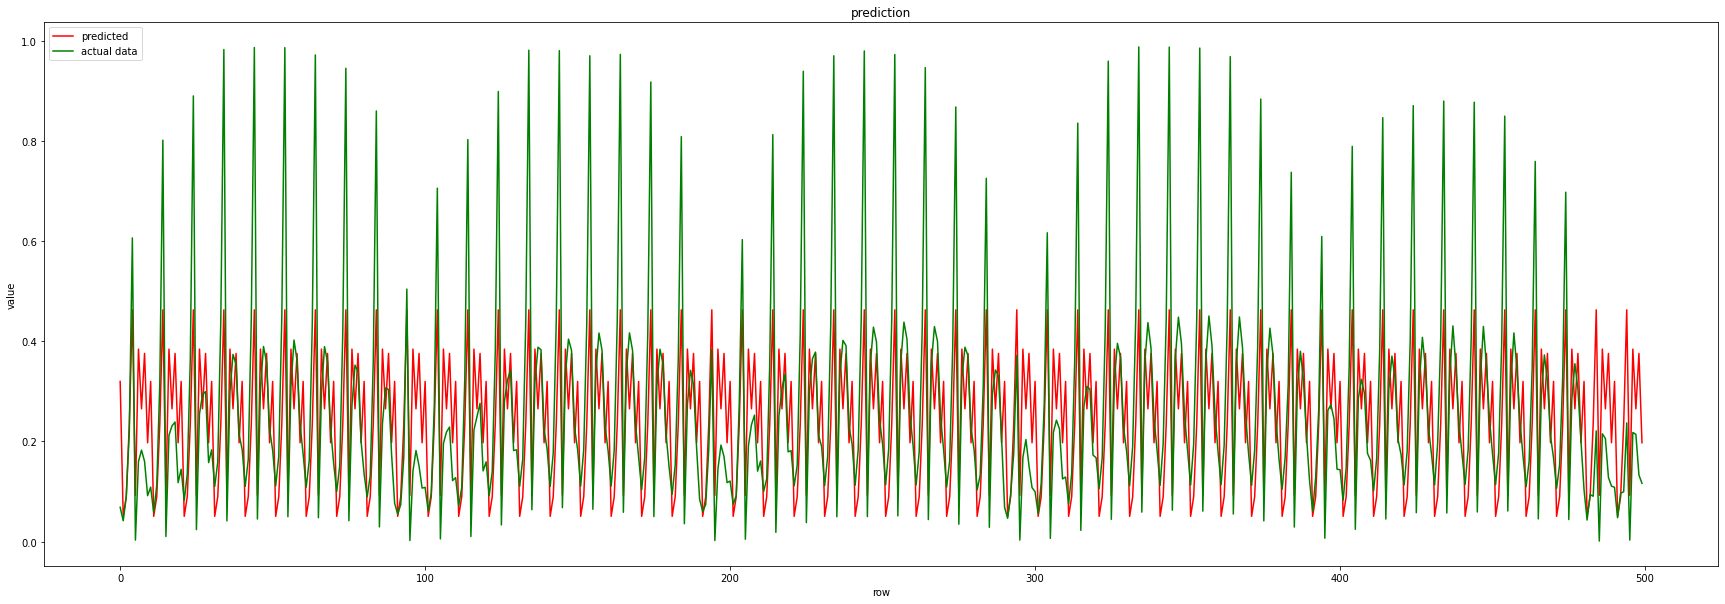

NN: Score: 0.150628


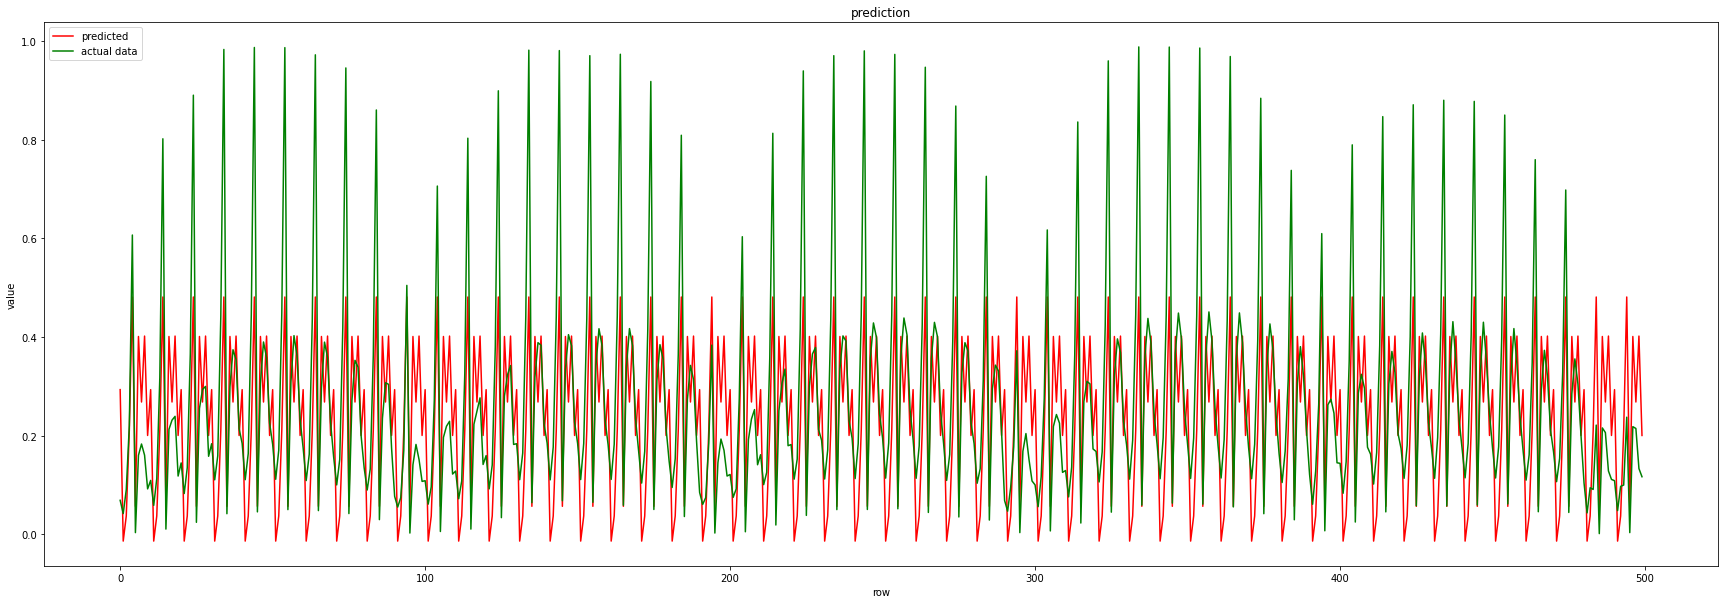

KNN: Score: 0.113636


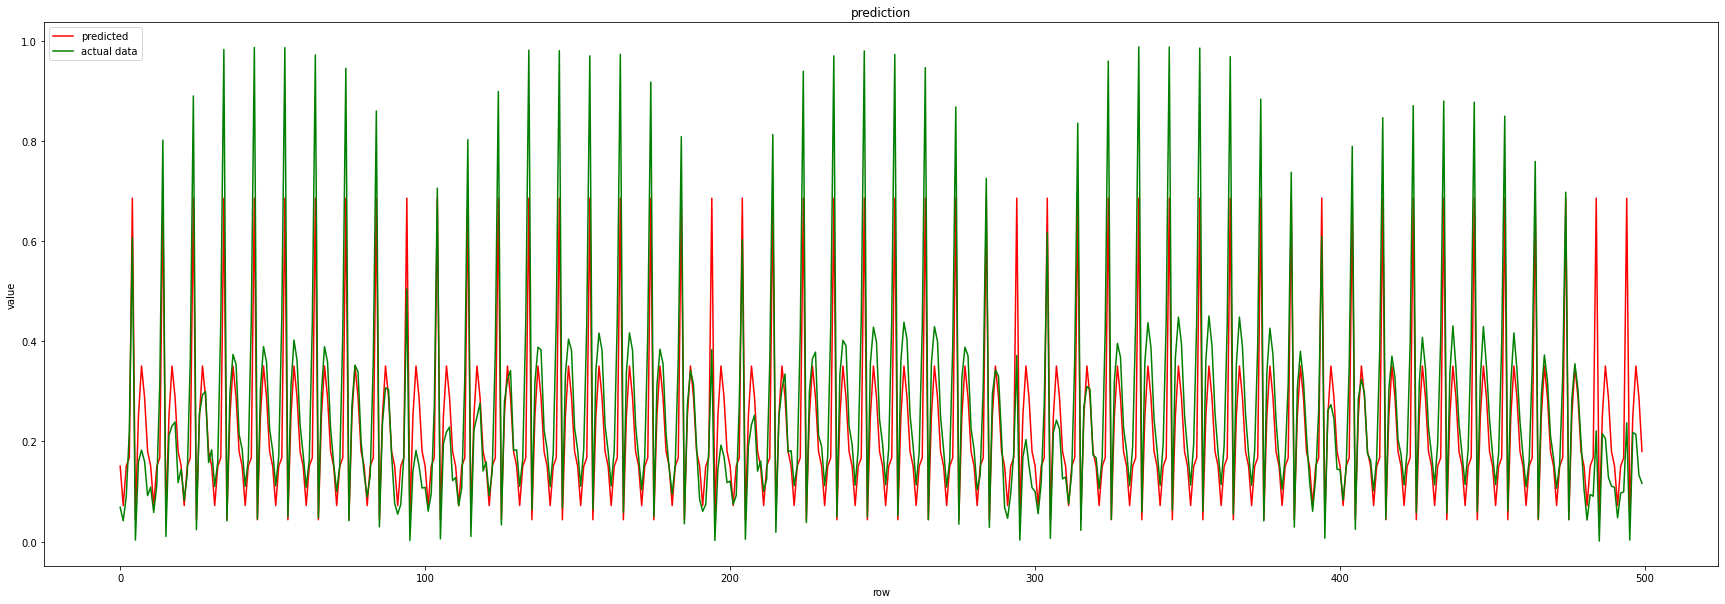

RF: Score: 0.101574


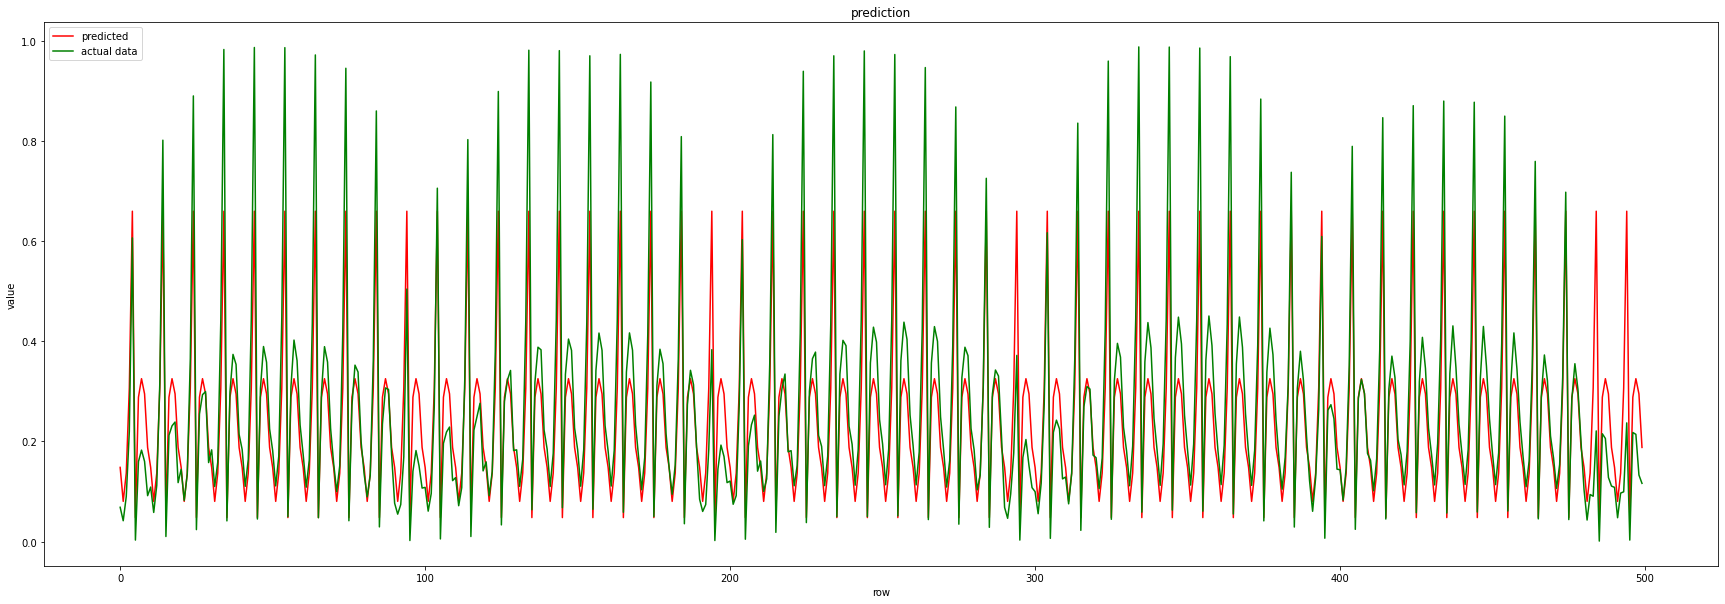

SVR: Score: 0.102324


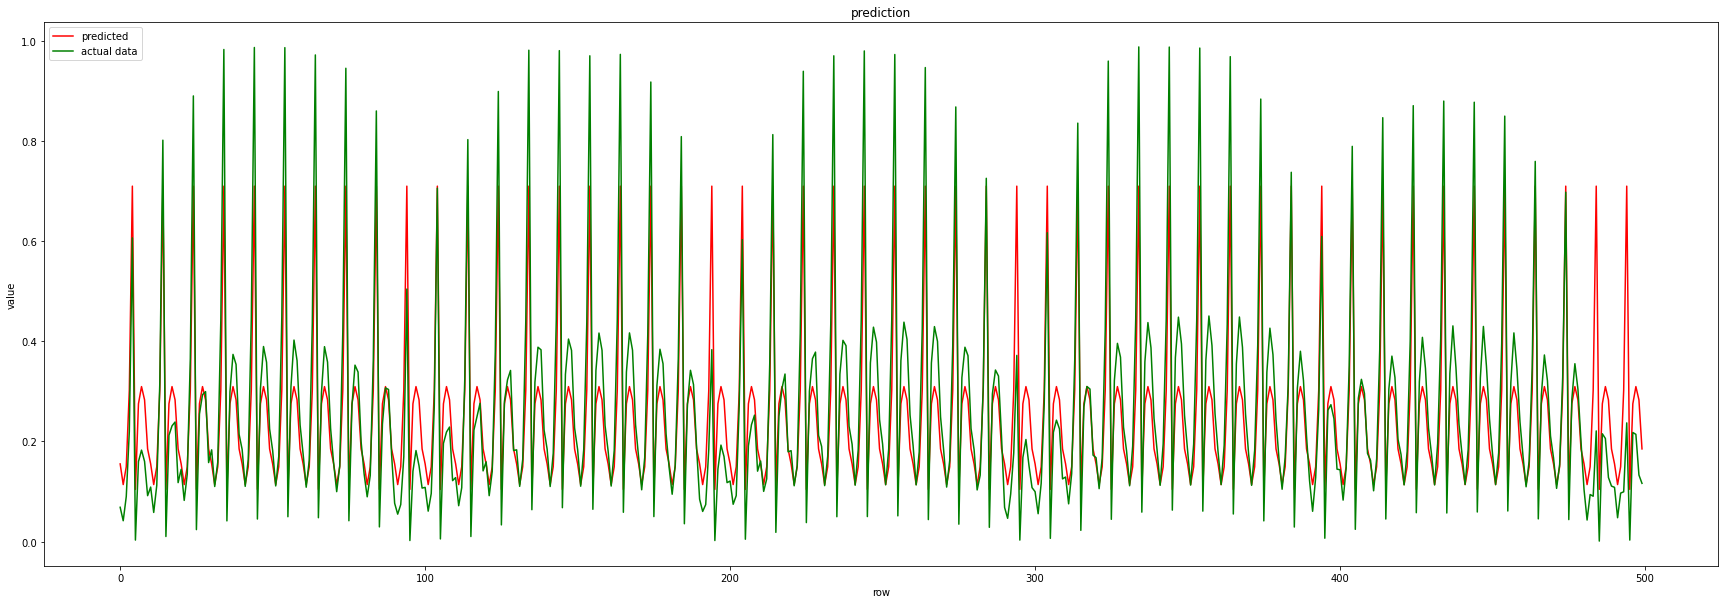

In [23]:
models = []
models.append(('XGB', XGBRegressor()))
models.append(('LR', LinearRegression()))
models.append(('NN', MLPRegressor(solver = 'lbfgs')))  
models.append(('KNN', KNeighborsRegressor())) 
models.append(('RF', RandomForestRegressor(n_estimators = 10))) 
models.append(('SVR', SVR(gamma='auto'))) 

# Evaluate each model in turn
results = {}
for name, model in models:
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    score = mean_squared_error(y_true = y_test, y_pred=pred, squared=False)
    results[name]= score
    print('%s: Score: %f' % (name, score))
    
    plot_compare_pred(pred[:500], list(y_test.values)[:500], name)

## RNN

In [24]:
from keras.layers import Dense,Dropout,SimpleRNN
from keras.models import Sequential

In [25]:
seq_len = 20

X_train = []
y_train = []
X_test = []
y_test = []

for i in range(seq_len, len(train_df)):
    X_train.append(train_df.iloc[i-seq_len : i, -1])
    y_train.append(train_df.iloc[i, -1])
    
for i in range(seq_len, len(test_df)):
    X_test.append(test_df.iloc[i-seq_len : i, -1])
    y_test.append(test_df.iloc[i, -1])

#3 convert to numpy array
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)
print(X_train.shape)

#4 reshape data to input into RNN models
X_train = np.reshape(X_train, (X_train.shape[0], seq_len, 1))
print(X_train.shape)

X_test = np.reshape(X_test, (X_test.shape[0], seq_len, 1))
print(X_test.shape)

(5300, 20)
(5300, 20, 1)
(1400, 20, 1)


In [26]:
model = Sequential()

model.add(SimpleRNN(100,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.2))

model.add(SimpleRNN(50,activation="tanh",return_sequences=True))
model.add(Dropout(0.2))

model.add(SimpleRNN(10,activation="tanh",return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 20, 100)           10200     
_________________________________________________________________
dropout (Dropout)            (None, 20, 100)           0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 20, 50)            7550      
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 50)            0         
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 10)                610       
_________________________________________________________________
dropout_2 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1

In [27]:
model.compile(optimizer="adam",loss="MSE")
model.fit(X_train, y_train, epochs=10, batch_size=1000)

Epoch 1/10
6/6 [==============================] - 0s 60ms/step - loss: 0.6299
Epoch 2/10
6/6 [==============================] - 0s 58ms/step - loss: 0.3623
Epoch 3/10
6/6 [==============================] - 0s 61ms/step - loss: 0.3012
Epoch 4/10
6/6 [==============================] - 0s 78ms/step - loss: 0.2465
Epoch 5/10
6/6 [==============================] - 0s 70ms/step - loss: 0.2073
Epoch 6/10
6/6 [==============================] - 0s 76ms/step - loss: 0.1695
Epoch 7/10
6/6 [==============================] - 0s 69ms/step - loss: 0.1405
Epoch 8/10
6/6 [==============================] - 0s 77ms/step - loss: 0.1189
Epoch 9/10
6/6 [==============================] - 0s 57ms/step - loss: 0.1040
Epoch 10/10
6/6 [==============================] - 0s 60ms/step - loss: 0.0908


In [28]:
pred = model.predict(X_test)

score = mean_squared_error(y_true = y_test, y_pred=pred, squared=False)
results["RNN"]= score
print("RMSE Score of RNN model = ",score)

RMSE Score of RNN model =  0.07731107497458253


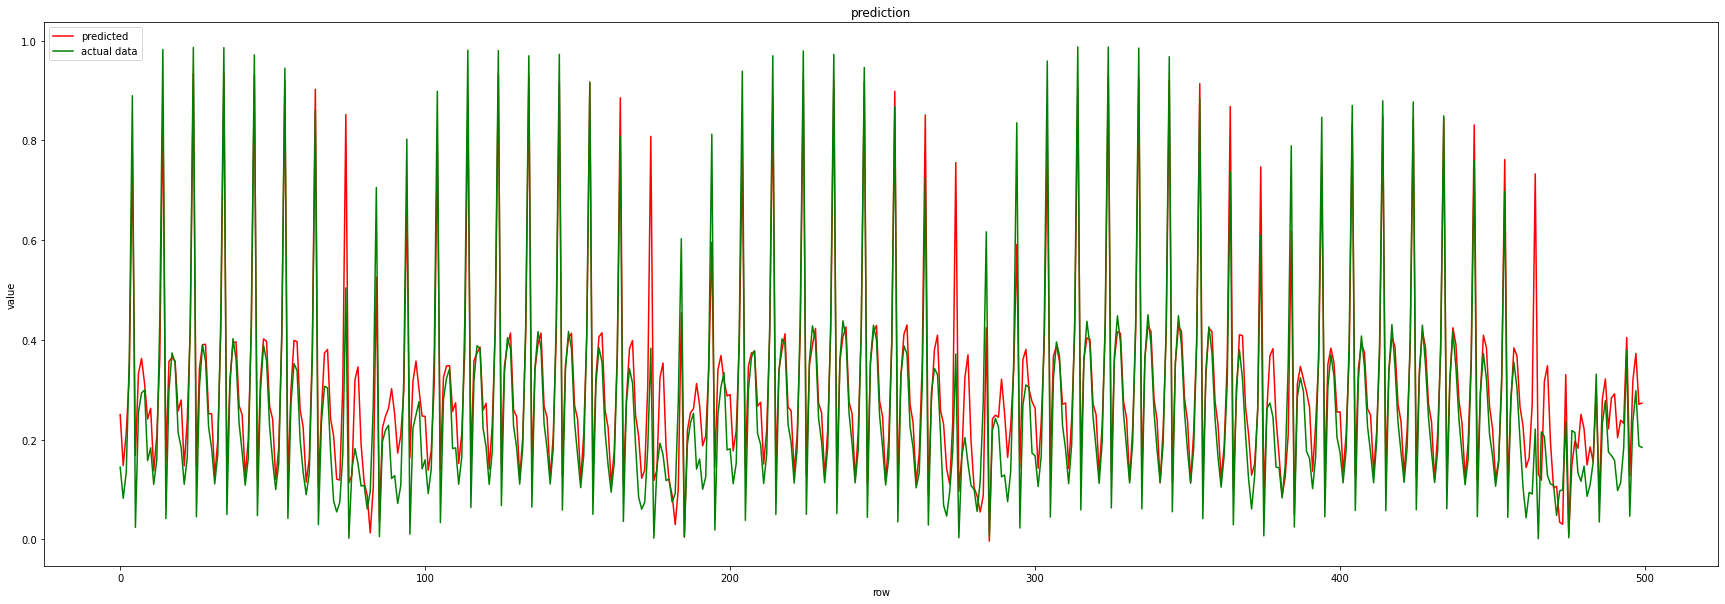

In [29]:
plot_compare_pred(pred[:500], y_test[:500], "RNN")

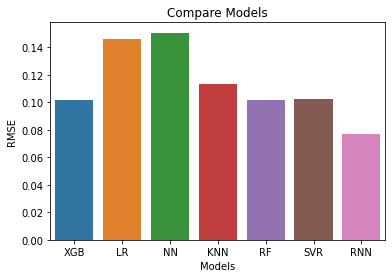

In [30]:
my_df = pd.DataFrame(results.items())
ax = sns.barplot(x=0, y=1, data=my_df)
ax.set(xlabel = 'Models', ylabel='RMSE', title='Compare Models')
plt.show()
plt.close()